In [16]:
import pyspark
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import langcodes
import plotly

In [4]:
from pyspark.sql import SparkSession

In [9]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import col, sum as spark_sum, avg, lower


In [ ]:
from pyspark import SparkContext

# Create a SparkContext object
sc = SparkContext()

In [1]:
spark = SparkSession \
.builder \
.appName("Project") \
.getOrCreate()

24/05/17 05:14:21 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [1]:
#Load the Dataset
df = spark.read.format("json").load("/data/ProjectDatasetFacebookAU")

24/05/19 12:48:37 ERROR TransportClient: Failed to send RPC RPC 8196497481105587064 to /100.64.72.78:45980: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source)
24/05/19 12:48:37 ERROR TransportClient: Failed to send RPC RPC 6197141900160446020 to /100.64.72.78:45996: io.netty.channel.StacklessClosedChannelException
io.netty.channel.StacklessClosedChannelException
	at io.netty.channel.AbstractChannel$AbstractUnsafe.write(Object, ChannelPromise)(Unknown Source)
24/05/19 12:48:37 ERROR TransportResponseHandler: Still have 1 requests outstanding when connection from /100.64.72.94:34104 is closed
24/05/19 12:48:37 ERROR TransportResponseHandler: Still have 1 requests outstanding when connection from /100.64.72.69:56468 is closed
24/05/19 12:48:37 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 2 from block manager BlockManagerId(44

In [6]:
df.printSchema()

root
 |-- ad_creation_time: string (nullable = true)
 |-- ad_creative_bodies: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_creative_body: string (nullable = true)
 |-- ad_creative_link_caption: string (nullable = true)
 |-- ad_creative_link_captions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_creative_link_description: string (nullable = true)
 |-- ad_creative_link_descriptions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_creative_link_title: string (nullable = true)
 |-- ad_creative_link_titles: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_delivery_start_time: string (nullable = true)
 |-- ad_delivery_stop_time: string (nullable = true)
 |-- ad_snapshot_url: string (nullable = true)
 |-- bylines: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- delivery_by_region: array (nullable = true)
 |    |-- element: struct (containsN

In [8]:
num_rows = df.count()
print(num_rows)

39584139


In [9]:
#getting total unique ad ids
unique_ad_ids = df.select(countDistinct("id")).collect()[0][0]
print(unique_ad_ids)

11852904


In [36]:
#getting number of null ad  id rows
null_ads_count = df.where(col("id").isNull()).count()
print(null_ads_count)

0


Analysis of Ad Creation Trends Over Time

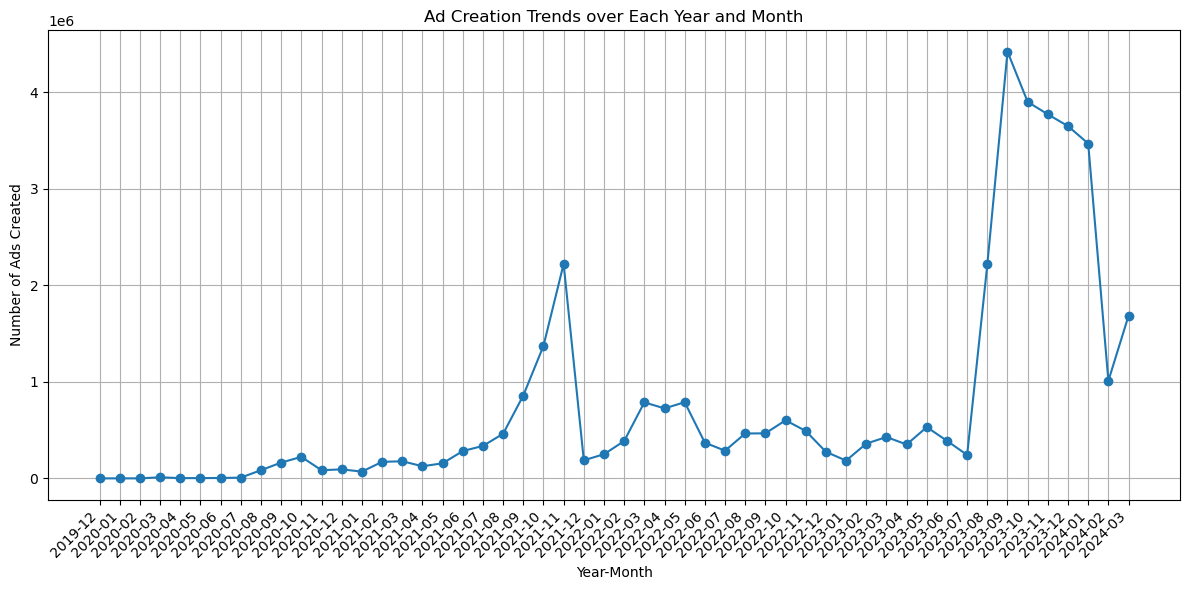

In [7]:
# Extract year and month from ad_creation_time and combine into a new column 'year_month'
df = df.withColumn("year_month", date_format("ad_creation_time", "yyyy-MM"))

# Calculate count of ad creations by year_month
year_month_ad_count = df.groupBy("year_month").count().orderBy("year_month")

# Convert DataFrame to Pandas for visualization
year_month_ad_count_pd = year_month_ad_count.toPandas()

# Plotting ad creation trends over each year and month
plt.figure(figsize=(12, 6))
plt.plot(year_month_ad_count_pd["year_month"], year_month_ad_count_pd["count"], marker='o')
plt.title("Ad Creation Trends over Each Year and Month")
plt.xlabel("Year-Month")
plt.ylabel("Number of Ads Created")
plt.xticks(rotation=45, ha='right')  
plt.grid(True)
plt.tight_layout()  
plt.savefig('Project/1.png')
plt.show()

In [13]:
currency_unit = df.select("currency").distinct().collect()[0]["currency"]
print("Currency Unit:", currency_unit)

# Check the spend range for a sample ad
sample_ad_spend = df.select("spend.lower_bound", "spend.upper_bound").limit(1).collect()[0]
print("Spend Range:", sample_ad_spend["lower_bound"], "-", sample_ad_spend["upper_bound"])


Currency Unit: AUD


Spend Range: 100 - 199


In [14]:
from pyspark.sql.functions import col, max, min

# Filter ads where spend values are not null
df_filtered = df.filter(col("spend.lower_bound").isNotNull())

# Find the highest and lowest amounts spent
highest_spend = df_filtered.select(max("spend.upper_bound")).collect()[0][0]
lowest_spend = df_filtered.select(min("spend.lower_bound")).collect()[0][0]

# Print the highest and lowest amounts spent
print("Highest Amount Spent:", highest_spend)
print("Lowest Amount Spent:", lowest_spend)

24/05/16 11:54:52 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Highest Amount Spent: 99999
Lowest Amount Spent: 0


Analysis of Top Languages Based on the Number of Ads Created

   language language_name  ad_count
0        en       English  20064018
20       es       Spanish    723741
10       pt    Portuguese    350715
80       fr        French    245030
18       de        German    216968
23       it       Italian    170036
78       zh       Chinese    157112
1        vi    Vietnamese    118555
63       ru       Russian    118429
82       id    Indonesian     87172


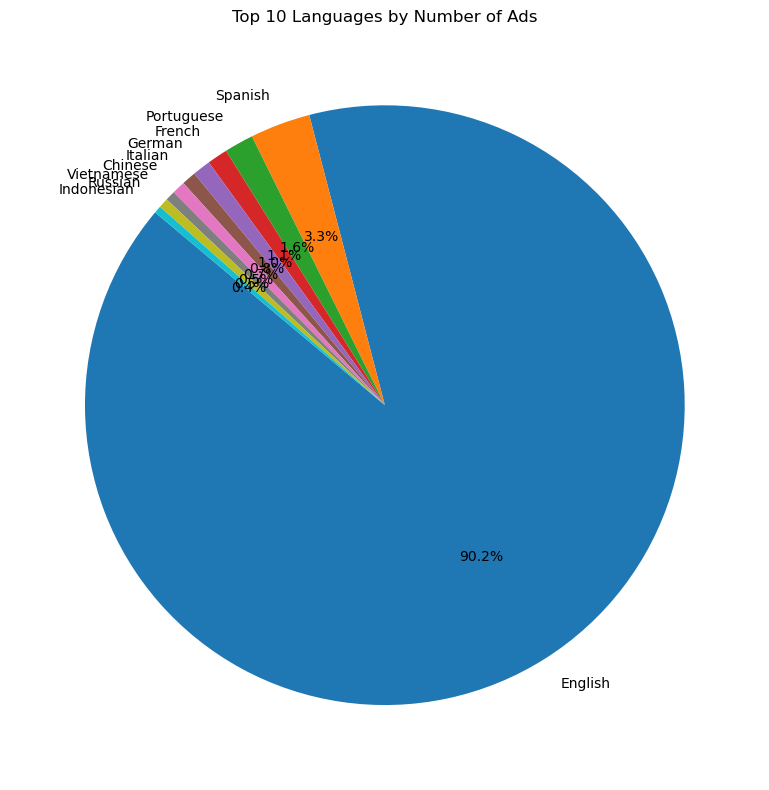

In [14]:
# Explode the languages array to get individual language entries
df_languages = df.withColumn("language", explode(col("languages")))

# Group by language and count the number of ads for each language
language_counts = df_languages.groupBy("language").agg(count("*").alias("ad_count"))

# Convert to Pandas DataFrame for visualization
language_counts_pd = language_counts.toPandas()

# Add a column with the full language names using langcodes
language_counts_pd['language_name'] = language_counts_pd['language'].apply(lambda x: langcodes.Language.get(x).display_name())

# Sort the DataFrame by ad count in descending order
language_counts_pd = language_counts_pd.sort_values(by='ad_count', ascending=False)

# Filter the top 10 languages
top_10_languages = language_counts_pd.head(10)

pd.set_option('display.max_rows', None)

# Print the top 10 languages and their ad counts along with language names
print(top_10_languages[['language', 'language_name', 'ad_count']])

# Plot the data
plt.figure(figsize=(10, 8))
plt.pie(top_10_languages["ad_count"], labels=top_10_languages["language_name"], autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Languages by Number of Ads')
plt.tight_layout()
# Save the plot to a file
plt.savefig('Project/3langPieChart.png')
plt.show()


Analysis of Demographic Distribution of Ads Based on the Age Group

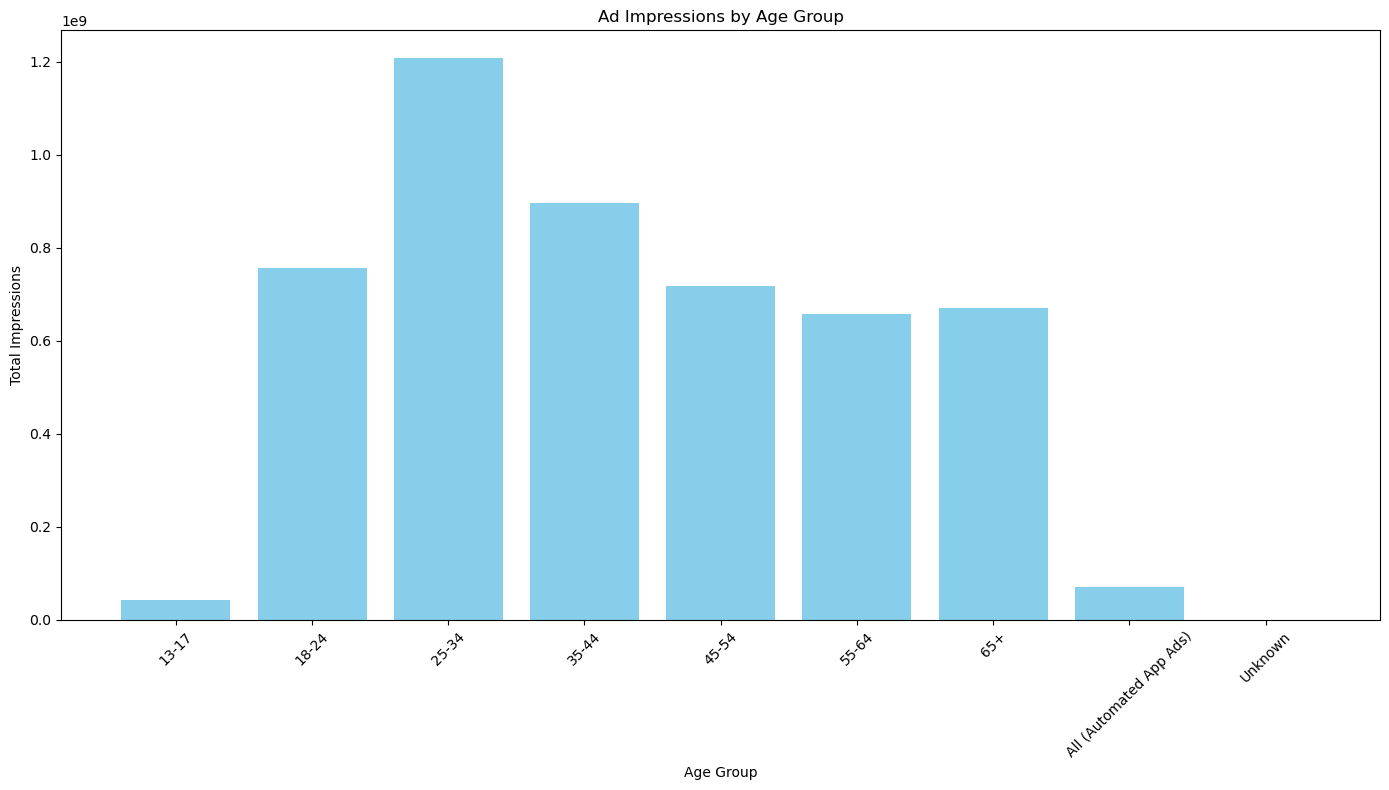

In [19]:
from pyspark.sql.functions import explode, col, sum as spark_sum

# Explode the demographic_distribution array to get individual demographic entries
df_demo = df.withColumn("demographic", explode(col("demographic_distribution")))

# Extract age information from the demographic struct
df_demo_age = df_demo.withColumn("age", col("demographic.age"))

# Group by age and calculate total impressions
age_group_impressions = df_demo_age.groupBy("age").agg(
    spark_sum(col("demographic.percentage").cast("double") * col("impressions.lower_bound").cast("double") / 100).alias("total_impressions")
).orderBy("age")

# Convert to Pandas DataFrame for visualization
age_group_impressions_pd = age_group_impressions.toPandas()

# Plot the data
plt.figure(figsize=(14, 8))
plt.bar(age_group_impressions_pd["age"], age_group_impressions_pd["total_impressions"], color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Total Impressions')
plt.title('Ad Impressions by Age Group')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot to a file
plt.savefig('Project/4ad_impressions_by_age_group.png')

# Show the plot
plt.show()


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


                                      funding_entity  total_spend
0                       Greenpeace Australia Pacific  657014800.0
1                                  Australian Unions  580649900.0
2                      Department of Social Services  294461200.0
3  Department of Industry, Science, Energy and Re...  293113700.0
4                                      WWF-Australia  219810300.0
5                                Australia for UNHCR  176873500.0
6                  Koffels Solicitors and Barristers  158760800.0
7                       Plan International Australia  129357500.0
8  Australian Government Department of Agricultur...  106550600.0
9                      Great Barrier Reef Foundation  101477900.0


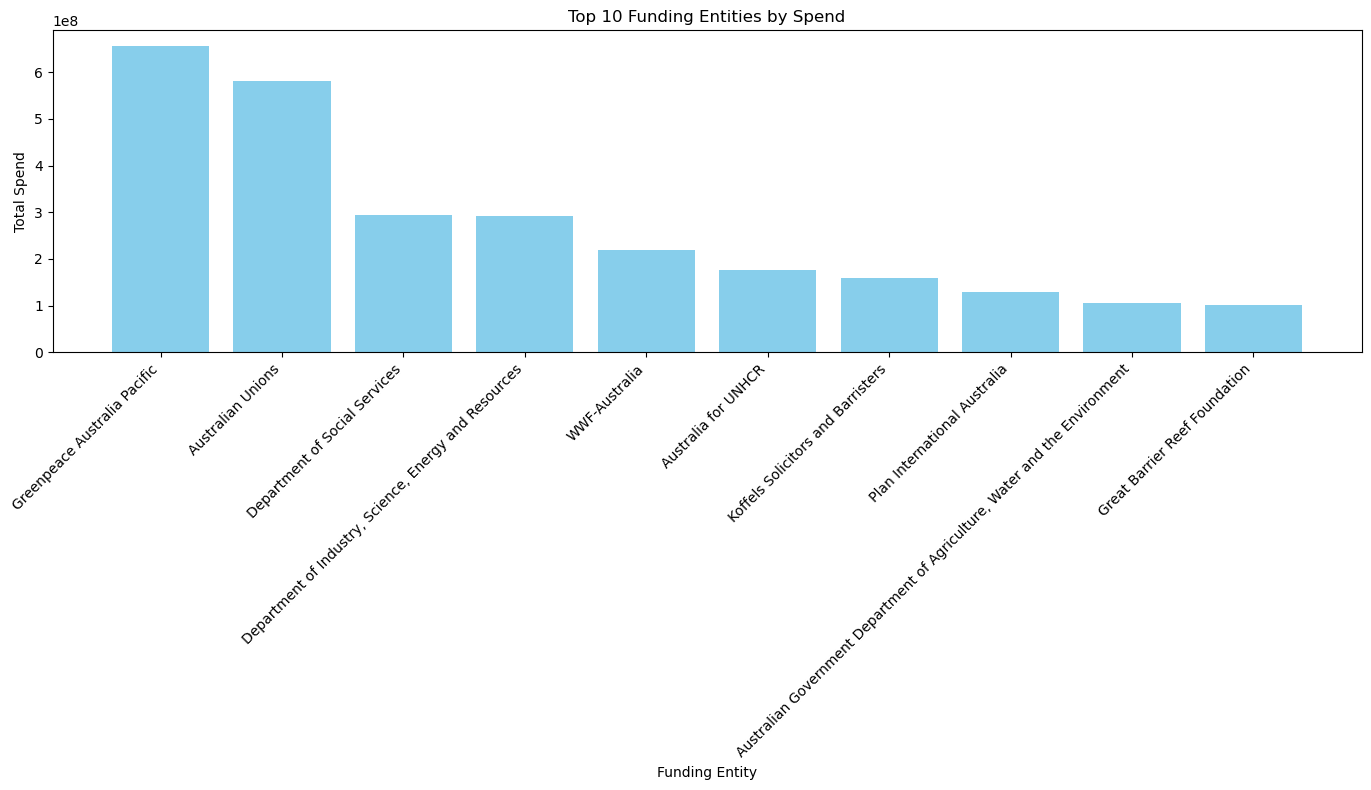

In [22]:
from pyspark.sql.functions import sum as spark_sum

# Filter out rows where the spend values are not null and the funding_entity is not null
df_filtered = df.filter(col("spend.lower_bound").isNotNull() & col("funding_entity").isNotNull())

# Group by funding entity and calculate total spend
funding_entity_spend = df_filtered.groupBy("funding_entity").agg(
    spark_sum(col("spend.lower_bound").cast("double")).alias("total_spend")
).orderBy(col("total_spend").desc())

# Convert to Pandas DataFrame for visualization
funding_entity_spend_pd = funding_entity_spend.toPandas()

# Filter out rows where funding_entity is not null
funding_entity_spend_pd = funding_entity_spend_pd.dropna(subset=["funding_entity"])

# Print the top 10 funding entities by spend
print(funding_entity_spend_pd.head(10))

# Plot the data for the top 10 funding entities
top_10_funding_entities = funding_entity_spend_pd.head(10)
plt.figure(figsize=(14, 8))
plt.bar(top_10_funding_entities["funding_entity"], top_10_funding_entities["total_spend"], color='skyblue')
plt.xlabel('Funding Entity')
plt.ylabel('Total Spend')
plt.title('Top 10 Funding Entities by Spend')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the plot to a file
plt.savefig('Project/top_10_funding_entities_by_spend.png')

# Show the plot
plt.show()


Analysis of Spends classified by Funding Entities

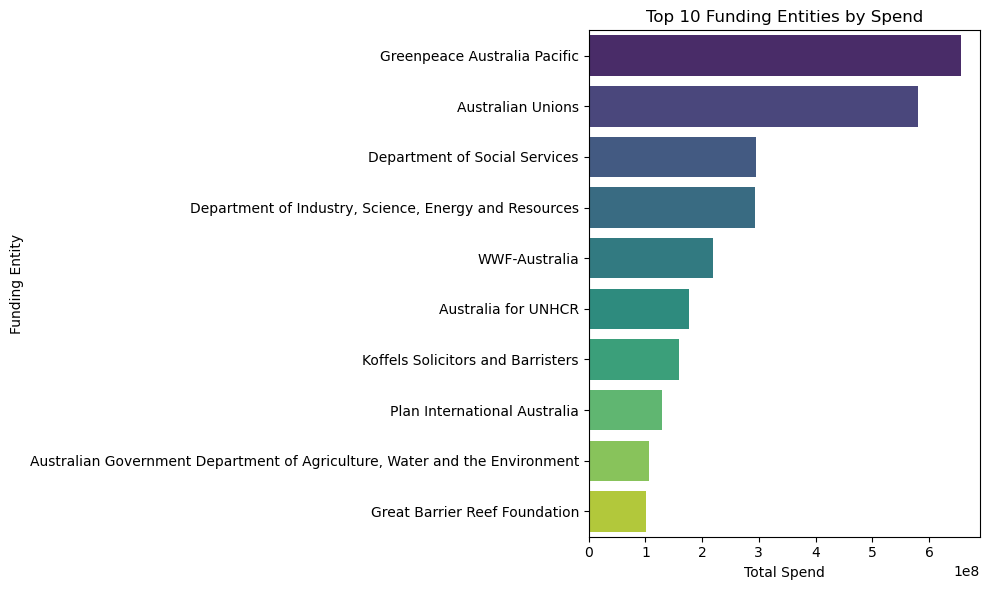

In [23]:
import seaborn as sns

# Filter out rows where the spend values are not null and the funding_entity is not null
df_filtered = df.filter(col("spend.lower_bound").isNotNull() & col("funding_entity").isNotNull())

# Group by funding entity and calculate total spend
funding_entity_spend = df_filtered.groupBy("funding_entity").agg(
    spark_sum(col("spend.lower_bound").cast("double")).alias("total_spend")
).orderBy(col("total_spend").desc())

# Convert to Pandas DataFrame for visualization
funding_entity_spend_pd = funding_entity_spend.toPandas()

# Filter out rows where funding_entity is not null
funding_entity_spend_pd = funding_entity_spend_pd.dropna(subset=["funding_entity"])

# Get the top 10 funding entities
top_10_funding_entities = funding_entity_spend_pd.head(10)

# Plot the data using a horizontal bar chart with color gradient
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", len(top_10_funding_entities))
sns.barplot(x="total_spend", y="funding_entity", data=top_10_funding_entities, palette=colors)

plt.xlabel('Total Spend')
plt.ylabel('Funding Entity')
plt.title('Top 10 Funding Entities by Spend')
plt.tight_layout()

# Save the plot to a file
plt.savefig('top_10_funding_entities_by_spend_horizontal.png')

# Show the plot
plt.show()


In [24]:
from pyspark.sql.functions import corr

# Calculate correlation between spend and impressions
correlation = df_filtered.select(
    col("spend.lower_bound").cast("double").alias("spend"),
    col("impressions.lower_bound").cast("double").alias("impressions")
).corr("spend", "impressions")

print(f"Correlation between spend and impressions: {correlation}")

Correlation between spend and impressions: 0.6206654689520306


Gender Distribution

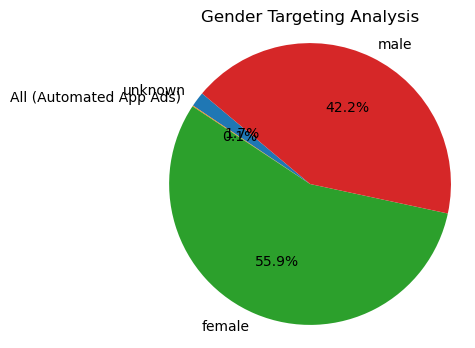

In [37]:
from pyspark.sql.functions import col, explode, sum as spark_sum
import matplotlib.pyplot as plt

# Filter out rows where demographic_distribution is not null
df_filtered = df.filter(col("demographic_distribution").isNotNull())

# Explode the demographic_distribution array to access gender and percentage
df_exploded = df_filtered.withColumn("demographic", explode("demographic_distribution")) \
    .select("demographic.gender", "demographic.percentage")

# Group by gender and calculate total percentage
gender_targeting = df_exploded.groupBy("gender").agg(
    spark_sum("percentage").alias("total_percentage")
)

# Convert to Pandas DataFrame for visualization
gender_targeting_pd = gender_targeting.toPandas()

# Set the figure size
plt.figure(figsize=(4, 4))

# Pie chart for gender targeting analysis
plt.pie(gender_targeting_pd["total_percentage"], labels=gender_targeting_pd["gender"], autopct='%1.1f%%', startangle=140)
plt.title("Gender Targeting Analysis")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('Project/6gender')
plt.show()


Study of Impressions based on spend and regions

In [4]:
from pyspark.sql.functions import col, explode, sum as spark_sum
from tabulate import tabulate
import pandas as pd

# Filter out rows where region_distribution is not null
df_filtered = df.filter(col("region_distribution").isNotNull())

# Explode the region_distribution array to access region, percentage, impressions, and spend
df_exploded = df_filtered.withColumn("region", explode("region_distribution.region")) \
    .withColumn("impressions_lower", col("impressions.lower_bound").cast("double")) \
    .withColumn("spend_lower", col("spend.lower_bound").cast("double")) \
    .select("region", "impressions_lower", "spend_lower")

# Group by region and calculate total impressions and spend
region_performance = df_exploded.groupBy("region").agg(
    spark_sum("impressions_lower").alias("total_impressions"),
    spark_sum("spend_lower").alias("total_spend")
)

# Convert to Pandas DataFrame for visualization
region_performance_pd = region_performance.toPandas()

# Sort by total impressions in descending order and get the top 10 highest impressions
top_10_highest = region_performance_pd.nlargest(10, "total_impressions")

# Sort by total impressions in ascending order and get the top 10 lowest impressions
bottom_10_lowest = region_performance_pd.nsmallest(10, "total_impressions")

# Visualize top 10 highest impressions
print("Top 10 Regions with Highest Impressions:")
print(tabulate(top_10_highest, headers='keys', tablefmt='pretty', showindex=False))


# Visualize top 10 lowest impressions
print("\nTop 10 Regions with Lowest Impressions:")
print(tabulate(bottom_10_lowest, headers='keys', tablefmt='pretty', showindex=False))


Top 10 Regions with Highest Impressions:
+------------------------------+-------------------+--------------+
|            region            | total_impressions | total_spend  |
+------------------------------+-------------------+--------------+
|           Victoria           |  406088743000.0   | 5435836500.0 |
|       New South Wales        |  390066901000.0   | 5131422900.0 |
|          Queensland          |  374073905000.0   | 4912557500.0 |
|       South Australia        |  361444203000.0   | 4729451900.0 |
|      Western Australia       |  354773190000.0   | 4751874800.0 |
|           Tasmania           |  342332989000.0   | 4638304800.0 |
|      Northern Territory      |  341510676000.0   | 4570453000.0 |
| Australian Capital Territory |  341388971000.0   | 4614255200.0 |
|     Jervis Bay Territory     |  264526496000.0   | 3660352500.0 |
|           Unknown            |  233877661000.0   | 3337481300.0 |
+------------------------------+-------------------+--------------+

Top 10

Analysis of top 5 parties based on the spend and classifying them on the yearly basis

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, sum as spark_sum, avg
from pyspark.sql.window import Window
from pyspark.sql.functions import rank


# Expanded list of known political party names and abbreviations
party_names = [
    "Liberal Party of Australia", "Australian Labor Party", "The Nationals", "Australian Greens",
    "Pauline Hanson's One Nation", "One Nation", "United Australia Party", "Clive Palmer",
    "Centre Alliance", "Katter's Australian Party", "Jacqui Lambie Network", "Animal Justice Party",
    "Liberal Democrats", "Australian Conservatives", "Shooters, Fishers and Farmers Party",
    "Derryn Hinch's Justice Party", "Sustainable Australia Party", "Australian Progressives",
    "Liberal", "Labor", "Nationals", "Greens", "UAP", "Centre Alliance", "KAP", "Lambie Network",
    "AJP", "LDP", "Conservatives", "Shooters", "Hinch", "SAP"
]

# Convert the party names to lowercase for case-insensitive search
party_names_lower = [name.lower() for name in party_names]

# Filter the DataFrame for funding entities containing any of the party names
party_ads = df.filter(
    lower(col("funding_entity")).rlike('|'.join(party_names_lower))
)

# Ensure spend.lower_bound and spend.upper_bound are numeric
party_ads = party_ads.withColumn("spend_lower_bound", col("spend.lower_bound").cast("double"))
party_ads = party_ads.withColumn("spend_upper_bound", col("spend.upper_bound").cast("double"))

# Calculate the average spend
party_ads = party_ads.withColumn("avg_spend", (col("spend_lower_bound") + col("spend_upper_bound")) / 2)

# Extract the year from ad_creation_time
party_ads = party_ads.withColumn("year", year(col("ad_creation_time")))

# Group by funding entity and year, and calculate total spend
yearly_spend = party_ads.groupBy("funding_entity", "year").agg(
    spark_sum("avg_spend").alias("total_spend")
)

# Define a window for ranking within each year
windowSpec = Window.partitionBy("year").orderBy(col("total_spend").desc())

# Rank the funding entities within each year based on total spend
yearly_spend = yearly_spend.withColumn("rank", rank().over(windowSpec))

# Filter to get the top 5 spending parties for each year
top_5_yearly_spend = yearly_spend.filter(col("rank") <= 10).orderBy(col("year"), col("rank"))

# Show the results
top_5_yearly_spend.show(truncate=False)



+---------------------------------+----+------------+----+
|funding_entity                   |year|total_spend |rank|
+---------------------------------+----+------------+----+
|LNP - Liberal National Party     |2020|4376750.5   |1   |
|Victorian Greens                 |2020|3264887.0   |2   |
|Pauline Hanson's One Nation Party|2020|2144293.0   |3   |
|Queensland Labor                 |2020|1835211.5   |4   |
|Liberals WA                      |2020|1467335.0   |5   |
|United Australia Party           |2020|1376515.0   |6   |
|the Canberra Liberals            |2020|1360548.0   |7   |
|Queensland Greens                |2020|1025600.5   |8   |
|Territory Labor                  |2020|1023615.0   |9   |
|Clive Palmer                     |2020|928874.5    |10  |
|Liberal Party of Australia       |2021|4.0072033E7 |1   |
|South Australian Labor           |2021|3.8232695E7 |2   |
|Pauline Hanson's One Nation Party|2021|2.24753665E7|3   |
|Australian Labor Party           |2021|5748132.5   |4  

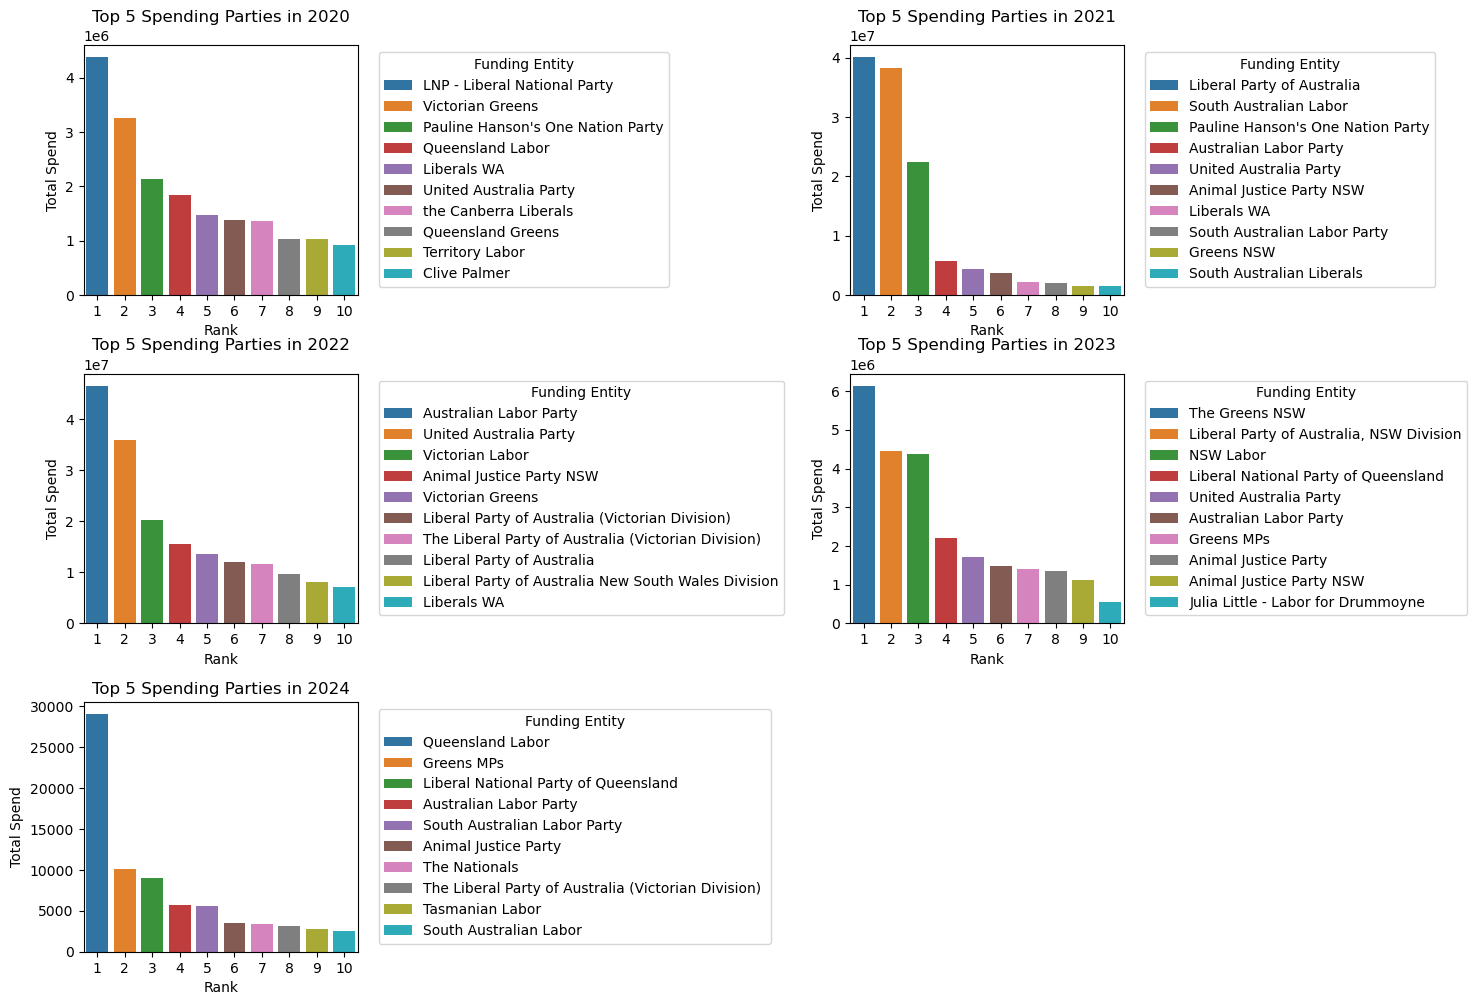

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the Spark DataFrame to a Pandas DataFrame for easier plotting
top_5_yearly_spend_pd = top_5_yearly_spend.select("funding_entity", "year", "rank", "total_spend").toPandas()

top_5_yearly_spend_pd['year'] = top_5_yearly_spend_pd['year'].astype(str)

# Get unique years in the data
unique_years = top_5_yearly_spend_pd['year'].unique()

# Set the color palette
distinct_colors = sns.color_palette("tab10", n_colors=top_5_yearly_spend_pd['funding_entity'].nunique())

# Determine the number of rows and columns for subplots (e.g., 2 rows x 2 columns if there are 4 years)
num_years = len(unique_years)
num_cols = 2
num_rows = (num_years + 1) // num_cols

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Create individual bar plots for each year
for i, year in enumerate(unique_years):
    ax = axes[i]
    
    # Filter data for the current year
    data_year = top_5_yearly_spend_pd[top_5_yearly_spend_pd['year'] == year]
    
    # Create a bar plot
    sns.barplot(data=data_year, x="rank", y="total_spend", hue="funding_entity", dodge=False, palette=distinct_colors, ax=ax)
    
    # Add titles and labels
    ax.set_title(f'Top 5 Spending Parties in {year}')
    ax.set_xlabel('Rank')
    ax.set_ylabel('Total Spend')
    
    # Display the legend
    ax.legend(title='Funding Entity', bbox_to_anchor=(1.05, 1), loc='upper left')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.savefig('Project/spendCombined.png')
plt.show()


Analysis of Distribution of Ads across Publishing Platforms

+----------------+--------+
|        platform|   count|
+----------------+--------+
|       instagram|26746879|
|       messenger|17736491|
|audience_network|17773400|
|        facebook|27630080|
+----------------+--------+



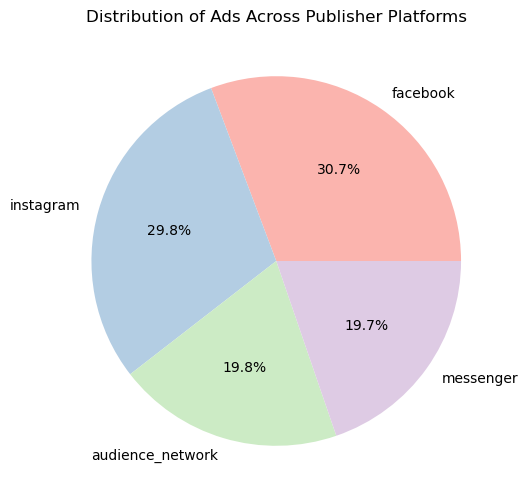

In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col

# Explode the publisher_platforms column to get each platform in a separate row
df_exploded = df.withColumn("platform", explode(col("publisher_platforms")))

# Count the number of ads for each platform
platform_ad_counts = df_exploded.groupBy("platform").count()

# Show the counts for each platform
platform_ad_counts.show()

# Order the table in descending order based on the count
platform_ad_counts_desc = platform_ad_counts.orderBy("count", ascending=False)

# Convert the Spark DataFrame to a Pandas DataFrame for easier plotting
platform_ad_counts_pd = platform_ad_counts_desc.toPandas()

# Plot a pie chart
plt.figure(figsize=(8, 6))
plt.pie(platform_ad_counts_pd["count"], labels=platform_ad_counts_pd["platform"], autopct='%1.1f%%', colors=plt.cm.Pastel1.colors)
plt.title("Distribution of Ads Across Publisher Platforms")
plt.savefig('Project/platformDist.png')
plt.show()


Audience Segmentation based on Age-Group and Gender

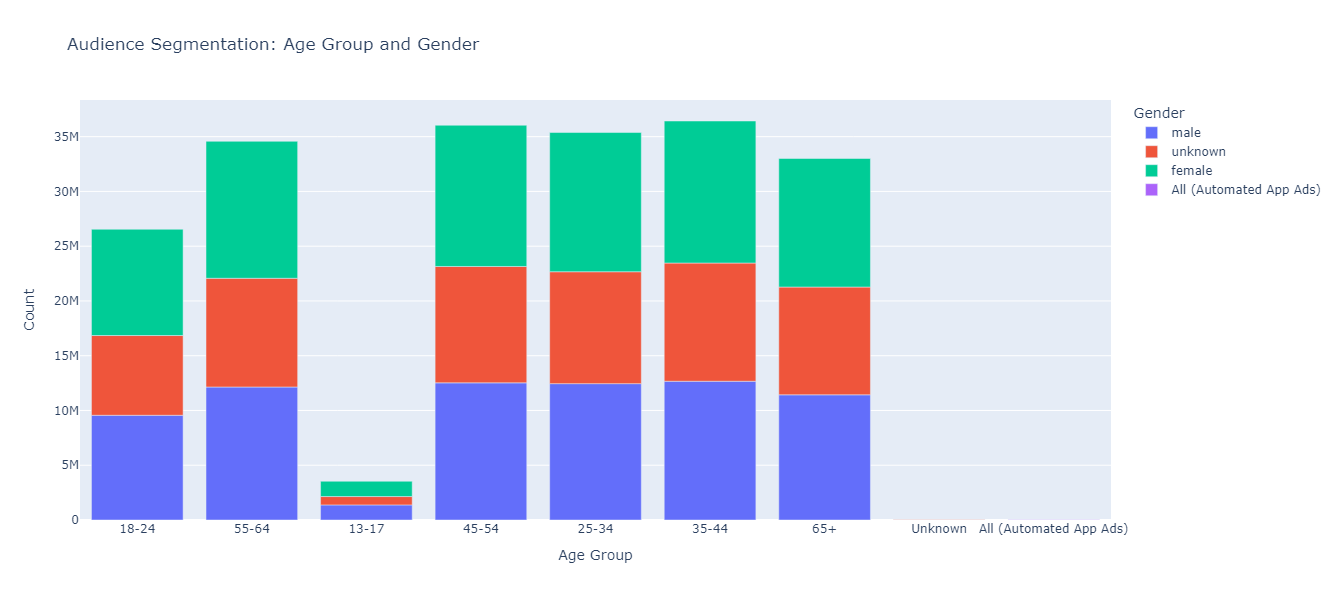

In [44]:
import plotly.express as px
import pandas as pd
from pyspark.sql.functions import explode, col

# Explode the demographic_distribution array to have each demographic entry in a separate row
df_exploded = df.withColumn("demographic", explode(col("demographic_distribution")))

# Parse demographic data into separate columns (e.g., age and gender)
df_parsed = df_exploded.select(
    col("demographic.age").alias("age"),
    col("demographic.gender").alias("gender"),
    # Add more columns for other demographic factors as needed
)

# Group by demographic factors and aggregate to count ads or impressions
segmented_data = df_parsed.groupBy("age", "gender").count()

# Convert to Pandas DataFrame for visualization
segmented_data_pd = segmented_data.toPandas()

# Plot a bar chart using Plotly Express
fig = px.bar(segmented_data_pd, x='age', y='count', color='gender',
             title='Audience Segmentation: Age Group and Gender',
             labels={'age': 'Age Group', 'count': 'Count', 'gender': 'Gender'})


fig.update_layout(width=800, height=600)


fig.show()
